In [21]:
import pandas as pd
import re
from datetime import datetime

# === Charger et préparer ===
df = pd.read_json("data_cleaned_opinion.json")
df['date'] = pd.to_datetime(df['date_parsed'], errors='coerce')
df = df.dropna(subset=['date'])

# === Paramètres ===
central_date = datetime(2022, 4, 2)  # Date du massacre révélé
window = pd.Timedelta(days=7)

periods = {
    "before": (central_date - 2 * window, central_date - window - pd.Timedelta(days=1)),
    "center": (central_date - window, central_date + window),
    "after":  (central_date + window + pd.Timedelta(days=1), central_date + 2 * window),
}

# === Mot-clé à tester ===
pattern = r"инсцениров"  # sans \b ni \w* pour attraper toutes les formes

# === Filtrage par période et mot-clé ===
def get_articles_in_period(df, date_range, keyword_pattern):
    start, end = date_range
    in_period = df['date'].between(start, end)
    has_keyword = df['full_text'].str.contains(keyword_pattern, flags=re.IGNORECASE, na=False, regex=True)
    return df[in_period & has_keyword]

# === Comptage ===
results = {}
for label, period in periods.items():
    filtered = get_articles_in_period(df, period, pattern)
    results[label] = len(filtered)

# === Affichage ===
for period in ["before", "center", "after"]:
    print(f"{period.capitalize()} : {results[period]} articles")


Before : 0 articles
Center : 0 articles
After : 0 articles


In [24]:
import pandas as pd

# Charger les données
df = pd.read_json("data_cleaned_opinion.json")
df['date'] = pd.to_datetime(df['date_parsed'], errors='coerce')
df = df.dropna(subset=['date'])

# Liste des racines associées à la mise en scène / propagande
keywords = [
    "буч",           # référence directe
    "инсцениров",    # mise en scène
    "фейк",          # fake
    "провокац",      # provocation
    "лож",           # mensonge
    "обвиня",        # accuser
    "сценар",        # scénario
    "манипуляц",     # manipulation
    "фальсифиц",     # falsification
    "врань",         # mensonge populaire
    "постановочн",   # mis en scène (adjectif)
    "спектакл",      # spectacle
    "театрал",       # théâtral
    "монтаж",        # montage
    "цель запад",    # objectif de l’Occident (percutant idéologiquement)
]

# Comptage
results = []
for k in keywords:
    count = df['full_text'].str.contains(k, case=False, na=False, regex=True).sum()
    results.append((k, count))

# Tri et affichage
results_sorted = sorted(results, key=lambda x: -x[1])
for k, c in results_sorted:
    print(f"{k:<15} → {c} articles")


лож             → 5331 articles
провокац        → 723 articles
обвиня          → 678 articles
сценар          → 563 articles
буч             → 491 articles
фейк            → 205 articles
манипуляц       → 131 articles
монтаж          → 106 articles
врань           → 90 articles
фальсифиц       → 80 articles
спектакл        → 71 articles
театрал         → 62 articles
постановочн     → 24 articles
инсцениров      → 17 articles
цель запад      → 6 articles


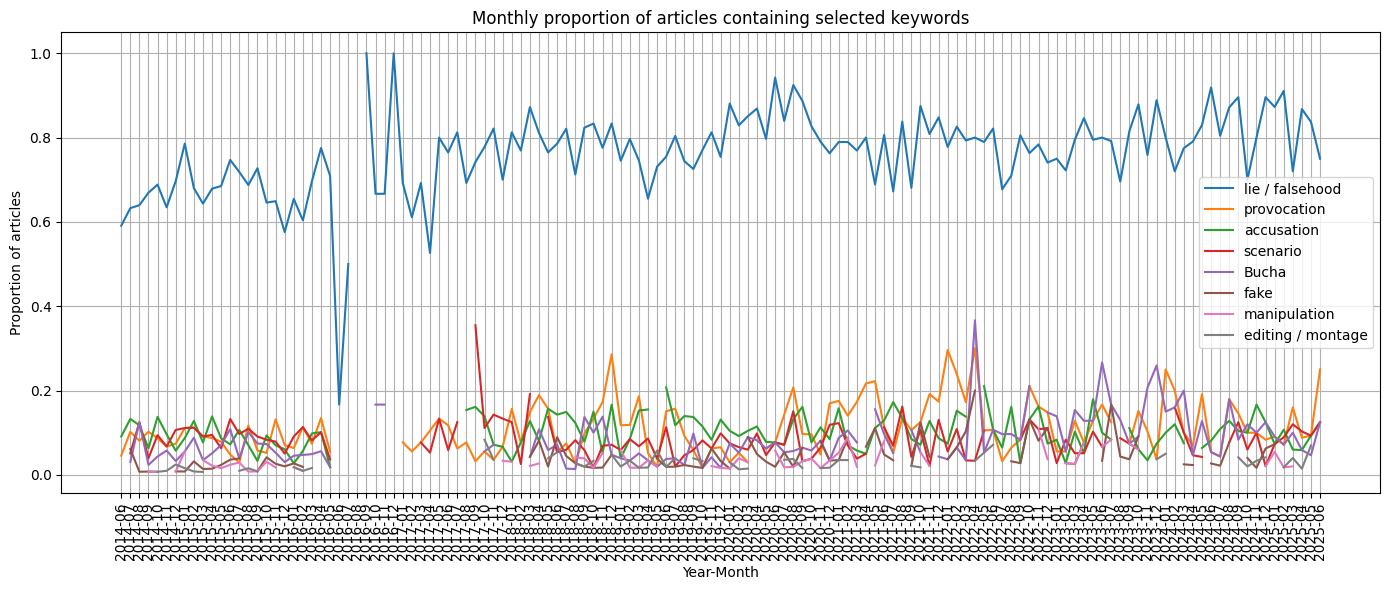

In [26]:

keywords = {
    "лож": "lie / falsehood",
    "провокац": "provocation",
    "обвиня": "accusation",
    "сценар": "scenario",
    "буч": "Bucha",
    "фейк": "fake",
    "манипуляц": "manipulation",
    "монтаж": "editing / montage",
}

# Total d'articles par mois
total_monthly = df['year_month'].value_counts().sort_index()

# Proportion d'articles par mot-clé
proportions = pd.DataFrame(index=total_monthly.index)

for key, label in keywords.items():
    matched = df[df['full_text'].str.contains(key, case=False, na=False, regex=True)].copy()
    counts = matched['year_month'].value_counts().sort_index()
    proportions[label] = counts / total_monthly

# Affichage du graphique
plt.figure(figsize=(14, 6))
for col in proportions.columns:
    plt.plot(proportions.index, proportions[col], label=col)

plt.title("Monthly proportion of articles containing selected keywords")
plt.xlabel("Year-Month")
plt.ylabel("Proportion of articles")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

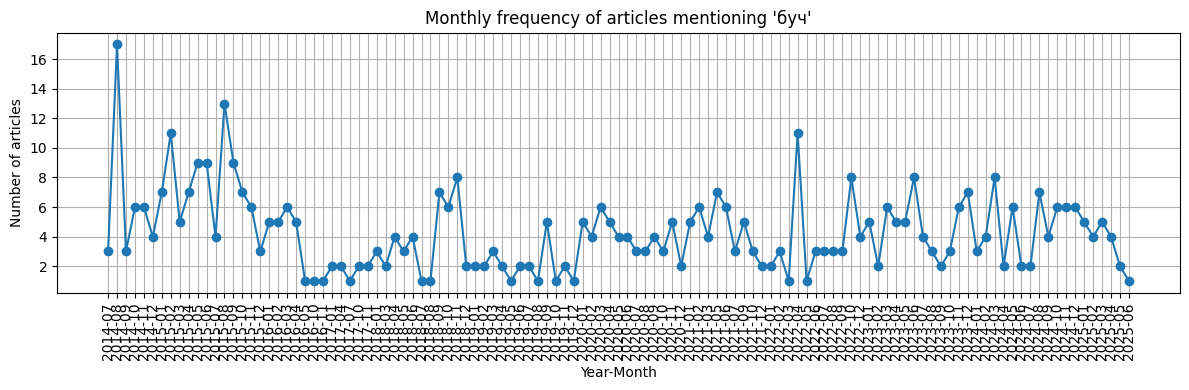

In [16]:
df_buch = df[df['full_text'].str.contains("буч", case=False, na=False)].copy()
df_buch['year_month'] = df_buch['date'].dt.to_period('M').astype(str)

counts = df_buch['year_month'].value_counts().sort_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(counts.index, counts.values, marker='o')
plt.xticks(rotation=90)
plt.title("Monthly frequency of articles mentioning 'буч'")
plt.xlabel("Year-Month")
plt.ylabel("Number of articles")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Filtrage des articles contenant Буча entre le 26 mars et le 9 avril 2022
df = pd.read_json("data_cleaned_opinion.json")
df['date'] = pd.to_datetime(df['date_parsed'], errors='coerce')
df = df.dropna(subset=['date'])

bucha_pattern = r"\bбуч\w*"
start, end = pd.to_datetime("2022-03-26"), pd.to_datetime("2022-04-09")
df_bucha = df[df['date'].between(start, end) & df['full_text'].str.contains(bucha_pattern, flags=re.IGNORECASE, na=False, regex=True)].copy()

# Préparation des textes
texts = df_bucha['full_text'].str.lower().tolist()

# Vectorisation
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=None, token_pattern=r'\b[а-яё]{4,}\b')
X = vectorizer.fit_transform(texts)

# LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# Affichage des topics
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top_words = [terms[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {idx+1}: {' '.join(top_words)}")


Topic 1: американские стала нашего ожидаемо опыт киева другим пытается главным выбор
Topic 2: американские стала нашего ожидаемо опыт киева другим пытается главным выбор
Topic 3: если даже надо военного кого можно потому этом долго украинские
Topic 4: после других совершенно буче вполне президент друг украина если очень
Topic 5: дальше есть конечно цели тогда всегда любой рамках именно перед


In [11]:
pip install razdel


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: razdel in c:\users\andraf\appdata\local\programs\python\python312\lib\site-packages (0.5.0)



In [15]:
from razdel import sentenize
from transformers import pipeline


def tokenize_sentences(text):
    return [s.text for s in sentenize(text)]

df_bucha['sentences'] = df_bucha['full_text'].apply(tokenize_sentences)


# Chargement modèle (doit être un modèle fine-tuné sur des techniques de propagande)

clf = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=0)
clf("Россия организовала постановку в Буче", candidate_labels=["propaganda", "neutral", "reporting"])


# Classification phrase par phrase
def score_article(sentences):
    results = clf(
        sentences,
        candidate_labels=["propaganda", "neutral", "reporting"],
        truncation=True,
        max_length=512
    )
    if isinstance(results, dict): 
        results = [results]
    n_total = len(results)
    n_propaganda = sum(1 for r in results if r['labels'][0].lower() == 'propaganda')
    return n_propaganda, n_total

df_bucha[['propaganda_count', 'total_sentences']] = df_bucha['sentences'].apply(lambda sents: pd.Series(score_article(sents)))
df_bucha['propaganda_ratio'] = df_bucha['propaganda_count'] / df_bucha['total_sentences']


Device set to use cuda:0


C:\Users\Andraf\AppData\Local\Temp\ipykernel_18792\2412308501.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


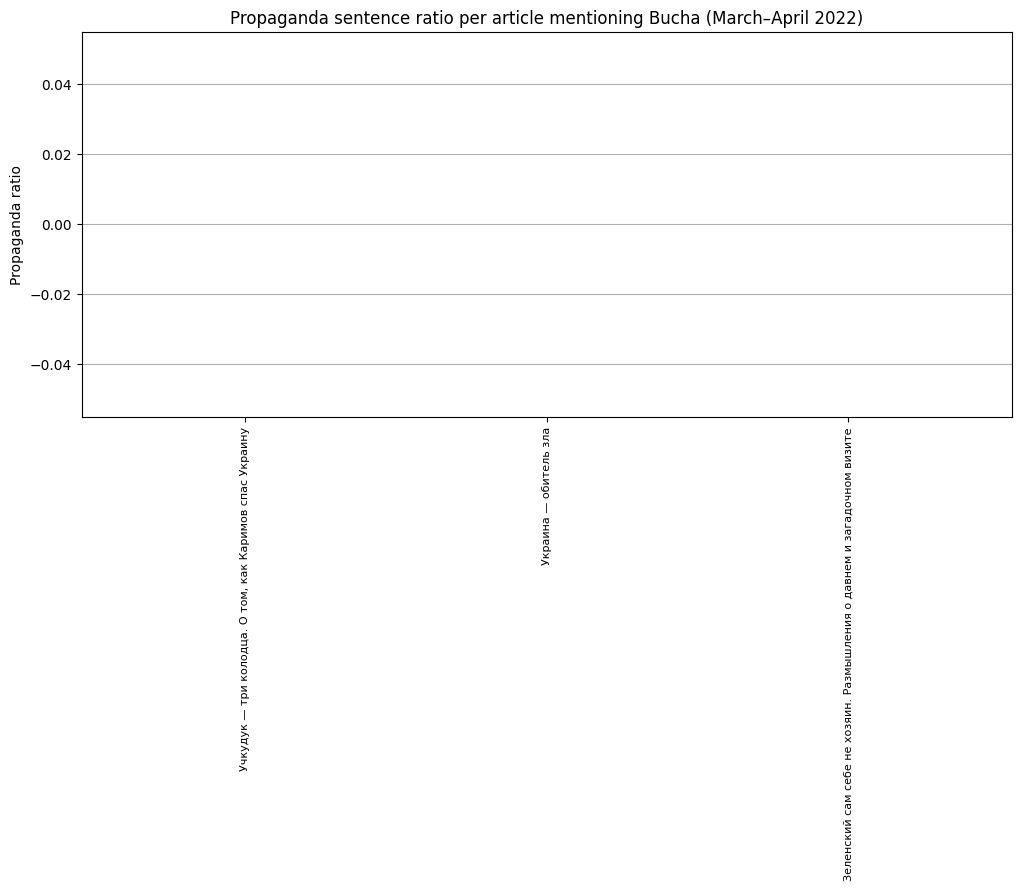

In [16]:
import matplotlib.pyplot as plt

# Sort by propaganda_ratio
df_plot = df_bucha.sort_values(by='propaganda_ratio', ascending=False).reset_index()

plt.figure(figsize=(12, 5))
plt.bar(range(len(df_plot)), df_plot['propaganda_ratio'], color='red')
plt.xticks(ticks=range(len(df_plot)), labels=df_plot['title'], rotation=90, fontsize=8)
plt.ylabel("Propaganda ratio")
plt.title("Propaganda sentence ratio per article mentioning Bucha (March–April 2022)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
